In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

from sklearn.metrics import roc_auc_score

In [2]:
from src.helpers import read_comments_toxicity_csv, predict_toxicity_probs, stratified_train_test_split
from src.toxicity_model import build_toxicity_model

Четверта домашня робота: теж змагання на кагл (можна командами по 3 людини). Потрібно класифікувати текст по декільком колонкам
Вимоги ті самі до репорту (оцінка за репорт буде 30 балів і 70 за репозиторій), додатково потрібно зробити гітхаб репозиторій для команди.

В репозиторії мають бути:
- github actions для перевірки стилю (ruff, etc), тестування коду (pytest, etc.) - 15 балів
- детальний README  - 10 балів
- Ваги фінальної моделі - 5 балів
- Inference скрипт який буде скачувати ваги моделі з github і робити передбачення для поданого тексту - 15 балів
- тести коду, мінімально допустими test coverage 40%  - 25 балів
- папки організувати наступним чином:
    - .github/worflows
    - EDA - ноутбуки з аналізом даних, підрахунком статистик і тд
    - configs - конфіги ваших тренувань ч
    - src - ваш код
    - tests - тести для вашого коду 
    - requirements.txt 
    - Dockerfile (за бажанням)

In [3]:
RANDOM_STATE = 42

Зчитаємо датасет та оцінимо його розміри та повноту.

In [4]:
X_full, y_full = read_comments_toxicity_csv('../data/train.csv')

In [5]:
X_full.head()

,comment_text
id,
0000997932d777bf,Explanation\nWhy the edits made under my usern...
000103f0d9cfb60f,D'aww! He matches this background colour I'm s...
000113f07ec002fd,"Hey man, I'm really not trying to edit war. It..."
0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ..."
0001d958c54c6e35,"You, sir, are my hero. Any chance you remember..."


In [6]:
X_full.info()

<class 'pandas.core.frame.DataFrame'>
Index: 159571 entries, 0000997932d777bf to fff46fc426af1f9a
Data columns (total 1 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   comment_text  159571 non-null  object
dtypes: object(1)
memory usage: 2.4+ MB


In [7]:
y_full.head()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
id,,,,,,
0000997932d777bf,0,0,0,0,0,0
000103f0d9cfb60f,0,0,0,0,0,0
000113f07ec002fd,0,0,0,0,0,0
0001b41b1c6bb37e,0,0,0,0,0,0
0001d958c54c6e35,0,0,0,0,0,0


In [8]:
y_full.describe()

,toxic,severe_toxic,obscene,threat,insult,identity_hate
count,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000,159571.000000
mean,0.095844,0.009996,0.052948,0.002996,0.049364,0.008805
std,0.294379,0.099477,0.223931,0.054650,0.216627,0.093420
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


In [25]:
y_full.info()

<class 'pandas.core.frame.DataFrame'>
Index: 159571 entries, 0000997932d777bf to fff46fc426af1f9a
Data columns (total 6 columns):
 #   Column         Non-Null Count   Dtype
---  ------         --------------   -----
 0   toxic          159571 non-null  int64
 1   severe_toxic   159571 non-null  int64
 2   obscene        159571 non-null  int64
 3   threat         159571 non-null  int64
 4   insult         159571 non-null  int64
 5   identity_hate  159571 non-null  int64
dtypes: int64(6)
memory usage: 12.6+ MB


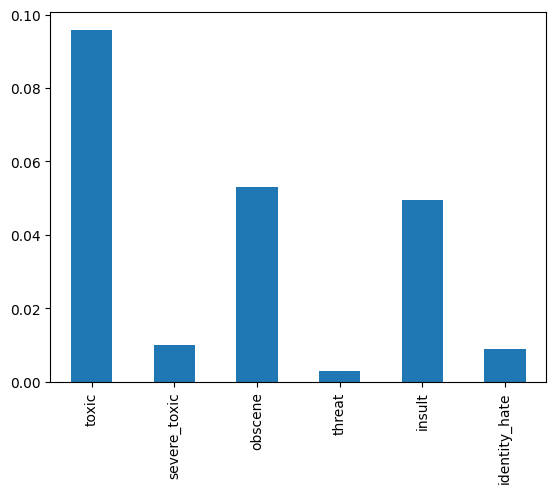

In [21]:
y_full.mean(axis='rows').plot(kind='bar');

In [31]:
X_train_full, X_test, y_train_full, y_test = stratified_train_test_split(X_full, y_full, random_state=RANDOM_STATE)
X_train, X_val, y_train, y_val = stratified_train_test_split(X_train_full, y_train_full, random_state=RANDOM_STATE)

## Бейзлайн

In [32]:
model = build_toxicity_model(max_features=100, random_state=RANDOM_STATE)

In [33]:
model.fit(X_train, y_train)

/Users/sonner/courses/uni/ml/ml_hw_final/.env/lib/python3.11/site-packages/sklearn/pipeline.py:377: UserWarning: Persisting input arguments took 0.57s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  X, fitted_transformer = fit_transform_one_cached(


Pipeline(memory='../tmp',
         steps=[('preprocess',
                 FunctionTransformer(func=<function preprocess_data_frame at 0x1412396c0>)),
                ('tfidf', TfidfVectorizer(max_features=100)),
                ('clf',
                 MultiOutputClassifier(estimator=LogisticRegression(max_iter=1000,
                                                                    n_jobs=6,
                                                                    random_state=42)))])

In [34]:
roc_auc_score(y_train, predict_toxicity_probs(X_train, model))

0.8849997142580693

In [35]:
roc_auc_score(y_val, predict_toxicity_probs(X_val, model))

0.8696808393700267

In [36]:
model_selection_results = []
for max_features in [100, 5000, 10000, 20000]:
    model = build_toxicity_model(max_features=max_features, random_state=RANDOM_STATE)
    model.fit(X_train, y_train)
    model_selection_results.append([
        max_features,
        roc_auc_score(y_train, predict_toxicity_probs(X_train, model)),
        roc_auc_score(y_val, predict_toxicity_probs(X_val, model)),
    ])

/Users/sonner/courses/uni/ml/ml_hw_final/.env/lib/python3.11/site-packages/sklearn/pipeline.py:377: UserWarning: Persisting input arguments took 0.76s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  X, fitted_transformer = fit_transform_one_cached(
/Users/sonner/courses/uni/ml/ml_hw_final/.env/lib/python3.11/site-packages/sklearn/pipeline.py:377: UserWarning: Persisting input arguments took 0.79s to run.If this happens often in your code, it can cause performance problems (results will be correct in all cases). The reason for this is probably some large input arguments for a wrapped function.
  X, fitted_transformer = fit_transform_one_cached(
/Users/sonner/courses/uni/ml/ml_hw_final/.env/lib/python3.11/site-packages/sklearn/pipeline.py:377: UserWarning: Persisting input arguments took 1.00s to run.If this happens often in your code, 

In [37]:
model_selection_df = pd.DataFrame(model_selection_results, columns=['max_features', 'train score', 'validation score'])
model_selection_df

,max_features,train score,validation score
0,100,0.885000,0.869681
1,5000,0.986097,0.976090
2,10000,0.987791,0.977954
3,20000,0.988839,0.978695


## Висновок

За допомогою станртних підходів обробки тексту розвʼязана (roc_auc_score > 0.97) задача multi label класифікації.

Результат оформлено у вигляді репозиторію з автоматизацією тренування, інференсу (batch та інтерактивного), тестами.